# Wildfire Damage Assessment (binary classification)

In [1]:
%load_ext autoreload

In [2]:
from wildfireassessment.ops import * #my package
from wildfireassessment.plots import * #my package
from wildfireassessment.test import *
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import morphology
from skimage.transform import resize
import pandas as pd
import geopandas as gpd
import pickle
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
from sklearn.externals import joblib
from rasterstats import zonal_stats
import fiona
%matplotlib inline

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
#read in filepaths for data

filepath_post = Path("./data/Paradise/post")
filepath_pre = Path("./data/Paradise/pre")

#WorldView Post/Pre
fps_wv_post = sorted(list(filepath_post.glob("2*_clip.tif")))
fps_wv_pre = sorted(list(filepath_pre.glob("2*_clip.tif")))

#WorldView Post/Pre
fps_sent2_post = sorted(list((filepath_post / "clippedB08s").glob("B08_*.tif")))
fps_sent2_pre = sorted(list((filepath_pre / "clippedB08s").glob("B08_*.tif")))

In [28]:
fps_wv_post[8:]

[PosixPath('data/Paradise/post/2011203_post_clip.tif')]

In [9]:
raster_src_post, rgb_post = readRGBImg(fps_wv_post[6])
raster_src_pre, rgb_pre = readRGBImg(fps_wv_pre[6])

In [10]:
raster_src_post_b08, b08_post = readOneImg(fps_sent2_post[6])
raster_src_pre_b08, b08_pre = readOneImg(fps_sent2_pre[6])

In [11]:
b08_upscaled_post = resize(b08_post, raster_src_post.shape, anti_aliasing=True)
b08_upscaled_post = b08_upscaled_post * 255
b08_upscaled_post = b08_upscaled_post.astype(rasterio.uint8)

In [12]:
b08_upscaled_pre = resize(b08_pre, raster_src_pre.shape, anti_aliasing=True)
b08_upscaled_pre = b08_upscaled_pre * 255
b08_upscaled_pre = b08_upscaled_pre.astype(rasterio.uint8)

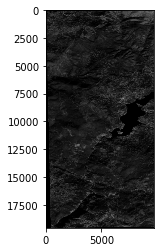

In [13]:
plt.imshow(b08_upscaled_post, cmap='gray')

## Extract pixels

#### unravel

In [14]:
rgb_rav_post = {0 : rgb_post[:,:,0].ravel().astype(float),
                1 : rgb_post[:,:,1].ravel().astype(float),
                2 : rgb_post[:,:,2].ravel().astype(float)}
rgb_rav_pre = {0 : rgb_pre[:,:,0].ravel().astype(float),
               1 : rgb_pre[:,:,1].ravel().astype(float),
               2 : rgb_pre[:,:,2].ravel().astype(float)}

In [15]:
b08_rav_post = b08_upscaled_post.ravel().astype(float)
b08_rav_pre = b08_upscaled_pre.ravel().astype(float)

In [16]:
rgb_rav_post[0]

array([ 0., 35., 26., ..., 72., 75.,  0.])

In [17]:
b08_rav_pre.shape[0]

190180224

In [18]:
b08_upscaled_post = None
b08_upscaled_pre = None
b08_post = None
b08_pre = None
rgb_pre = None
rgb_post = None

In [19]:
def computeSI(b1, b2):
    return (b1-b2)/(b1+b2)

def changedSI(SI_pre, SI_post):
    return SI_pre - SI_post

In [20]:
def makeChunkX(b, g, r, n, b_p, g_p, r_p, n_p):
    SI_gb = (computeSI(g, b), computeSI(g_p, b_p)) #(post, pre)
    SI_rb = (computeSI(r, b), computeSI(r_p, b_p))
    SI_rg = (computeSI(r, g), computeSI(r_p, g_p))
    SI_nb = (computeSI(n, b), computeSI(n_p, b_p))
    SI_ng = (computeSI(n, g), computeSI(n_p, g_p))
    SI_nr = (computeSI(n, r), computeSI(n_p, r_p))
    
    dSI_gb = changedSI(SI_gb[1], SI_gb[0])
    dSI_rb = changedSI(SI_rb[1], SI_rb[0])
    dSI_rg = changedSI(SI_rg[1], SI_rg[0])
    dSI_nb = changedSI(SI_nb[1], SI_nb[0])
    dSI_ng = changedSI(SI_ng[1], SI_ng[0])
    dSI_nr = changedSI(SI_nr[1], SI_nr[0])
    
    return np.dstack((b, b_p, g, g_p, r, r_p, n, n_p,
                      SI_gb[0], SI_rb[0], SI_rg[0], SI_nb[0], SI_ng[0], SI_nr[0],
                      SI_gb[1], SI_rb[1], SI_rg[1], SI_nb[1], SI_ng[1], SI_nr[1],
                      dSI_nb, dSI_rg, dSI_rb, dSI_gb, dSI_nr, dSI_ng))[0]

In [21]:
X_chunk = makeChunkX(rgb_rav_post[2][0:100], rgb_rav_post[1][0:100], rgb_rav_post[0][0:100], b08_rav_post[0:100],
           rgb_rav_pre[2][0:100], rgb_rav_pre[1][0:100], rgb_rav_pre[0][0:100], b08_rav_pre[0:100])

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [22]:
m = ma.masked_invalid(X_chunk)
ma.set_fill_value(m, -999)
m

masked_array(
  data=[[0.0, 0.0, 0.0, ..., --, --, --],
        [31.0, 50.0, 47.0, ..., 0.03729603729603731, 0.0, 0.0],
        [24.0, 35.0, 39.0, ..., 0.040255277368679454, 0.0, 0.0],
        ...,
        [76.0, 101.0, 106.0, ..., -0.13598901098901098, 0.0, 0.0],
        [79.0, 74.0, 108.0, ..., -0.09775537313941211, 0.0, 0.0],
        [87.0, 82.0, 118.0, ..., -0.09919639080783871, 0.0, 0.0]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-999.0)

In [23]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_chunk)
X_chunk_imp = imp.transform(X_chunk)

In [24]:
rf_model = joblib.load(open("models/rf_grid_bin_precision.pkl", 'rb'))

In [25]:
pred_y = rf_model.predict(X_chunk_imp)

### Test Random Forest

In [24]:
from joblib import Parallel, delayed
import multiprocessing

def processInParallel(i):
    X_chunk = makeChunkX(rgb_rav_post[2][i:i+100], rgb_rav_post[1][i:i+100], rgb_rav_post[0][i:i+100], b08_rav_post[i:i+100],
           rgb_rav_pre[2][i:i+100], rgb_rav_pre[1][i:i+100], rgb_rav_pre[0][i:i+100], b08_rav_pre[i:i+100])
    
    return rf_model.predict(ma.masked_invalid(X_chunk))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [30]:
%%time
num_cores = multiprocessing.cpu_count()
pred_y = Parallel(n_jobs=num_cores, backend="multiprocessing")(delayed(processInParallel)(i) for i in range(0, len(b08_rav_post), 100))
pred_y

CPU times: user 2min 8s, sys: 24.4 s, total: 2min 32s
Wall time: 11min 46s


[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=uint8),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [39]:
pred_y_rf = np.hstack(pred_y).reshape(raster_src_post.shape)

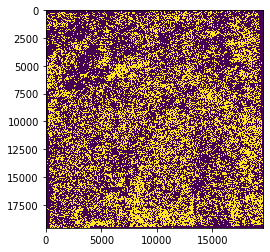

In [48]:
plt.imshow(pred_y_rf)

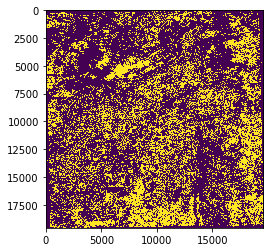

In [55]:
pred_y_rf_clean = morphology.remove_small_holes(pred_y_rf==1, 500) 
pred_y_rf_clean = morphology.remove_small_objects(pred_y_rf_clean, 500)
plt.imshow(pred_y_rf_clean)

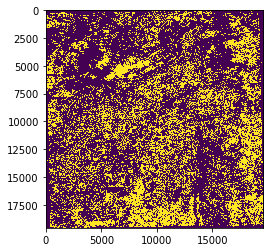

In [53]:
pred_y_rf_clean.astype(np.uint8)

In [65]:
raster_src_post.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 19584,
 'height': 19584,
 'count': 3,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(4.487879136029412e-06, 0.0, -121.640625,
        0.0, -4.487879136029412e-06, 39.814453125)}

In [72]:
metadata = {
    'driver': 'GTiff',
    'dtype': 'uint8',
    'width': 19584, 
    'height': 19584,
    'count': 1,
    'crs': raster_src_post.meta['crs'], 
    'transform': raster_src_post.meta['transform']
}
metadata

{'driver': 'GTiff',
 'dtype': 'uint8',
 'width': 19584,
 'height': 19584,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(4.487879136029412e-06, 0.0, -121.640625,
        0.0, -4.487879136029412e-06, 39.814453125)}

In [73]:
# with rasterio.open("results/predict_mask_rf_2011200_nclean.tif", 'w', **metadata) as dst:
#     dst.write(pred_y_rf.astype(np.uint8), 1)
    
with rasterio.open("results/predict_mask_rf_2011200.tif", 'w', **metadata) as dst:
    dst.write(pred_y_rf_clean.astype(np.uint8), 1)

In [3]:
#### Write to all datasets
writeRasters()

Reading filepaths...
Loading Model
Start reading images
Reading RGB...
Reading S2 B8...
Resizing B8 images
unravel rgb, b08
starting predictions with model


AttributeError: Can't pickle local object 'writeRasters.<locals>.processInParallel'

In [29]:
#read in filepaths for data
print("Reading filepaths...")
filepath_post = Path("./data/Paradise/post")
filepath_pre = Path("./data/Paradise/pre")

#WorldView Post/Pre
fps_wv_post = sorted(list(filepath_post.glob("2*_clip.tif")))
fps_wv_pre = sorted(list(filepath_pre.glob("2*_clip.tif")))

#WorldView Post/Pre
fps_sent2_post = sorted(list((filepath_post / "clippedB08s").glob("B08_*.tif")))
fps_sent2_pre = sorted(list((filepath_pre / "clippedB08s").glob("B08_*.tif")))

print("Loading Model")
#LOAD model
rf_model = joblib.load(open("models/rf_grid_bin_precision.pkl", 'rb'))

print("Start reading images")
for i in range(8, len(fps_wv_post)):
    print("Reading RGB...")
    raster_src_post, rgb_post = readRGBImg(fps_wv_post[i])
    raster_src_pre, rgb_pre = readRGBImg(fps_wv_pre[i])

    print("Reading S2 B8...")
    raster_src_post_b08, b08_post = readOneImg(fps_sent2_post[i])
    raster_src_pre_b08, b08_pre = readOneImg(fps_sent2_pre[i])

    print("Resizing B8 images")
    b08_upscaled_post = resize(b08_post, raster_src_post.shape, anti_aliasing=True)
    b08_upscaled_post = b08_upscaled_post * 255
    b08_upscaled_post = b08_upscaled_post.astype(rasterio.uint8)

    b08_upscaled_pre = resize(b08_pre, raster_src_pre.shape, anti_aliasing=True)
    b08_upscaled_pre = b08_upscaled_pre * 255
    b08_upscaled_pre = b08_upscaled_pre.astype(rasterio.uint8)

    print("unravel rgb, b08")
    #unravel
    rgb_rav_post = {0 : rgb_post[:,:,0].ravel().astype(float),
                    1 : rgb_post[:,:,1].ravel().astype(float),
                    2 : rgb_post[:,:,2].ravel().astype(float)}
    rgb_rav_pre = {0 : rgb_pre[:,:,0].ravel().astype(float),
                   1 : rgb_pre[:,:,1].ravel().astype(float),
                   2 : rgb_pre[:,:,2].ravel().astype(float)}

    b08_rav_post = b08_upscaled_post.ravel().astype(float)
    b08_rav_pre = b08_upscaled_pre.ravel().astype(float)

    #release mem
    b08_upscaled_post = None
    b08_upscaled_pre = None
    b08_post = None
    b08_pre = None
    rgb_pre = None
    rgb_post = None

    print("starting predictions with model")
    def computeSI(b1, b2):
        return (b1-b2)/(b1+b2)

    def changedSI(SI_pre, SI_post):
        return SI_pre - SI_post
    def computeSI(b1, b2):
        return (b1-b2)/(b1+b2)
    
    def changedSI(SI_pre, SI_post):
        return SI_pre - SI_post
    def makeChunkX(b, g, r, n, b_p, g_p, r_p, n_p):
        SI_gb = (computeSI(g, b), computeSI(g_p, b_p)) #(post, pre)
        SI_rb = (computeSI(r, b), computeSI(r_p, b_p))
        SI_rg = (computeSI(r, g), computeSI(r_p, g_p))
        SI_nb = (computeSI(n, b), computeSI(n_p, b_p))
        SI_ng = (computeSI(n, g), computeSI(n_p, g_p))
        SI_nr = (computeSI(n, r), computeSI(n_p, r_p))

        dSI_gb = changedSI(SI_gb[1], SI_gb[0])
        dSI_rb = changedSI(SI_rb[1], SI_rb[0])
        dSI_rg = changedSI(SI_rg[1], SI_rg[0])
        dSI_nb = changedSI(SI_nb[1], SI_nb[0])
        dSI_ng = changedSI(SI_ng[1], SI_ng[0])
        dSI_nr = changedSI(SI_nr[1], SI_nr[0])

        return np.dstack((b, b_p, g, g_p, r, r_p, n, n_p,
                          SI_gb[0], SI_rb[0], SI_rg[0], SI_nb[0], SI_ng[0], SI_nr[0],
                          SI_gb[1], SI_rb[1], SI_rg[1], SI_nb[1], SI_ng[1], SI_nr[1],
                          dSI_nb, dSI_rg, dSI_rb, dSI_gb, dSI_nr, dSI_ng))[0]
    def processInParallel(i):
        X_chunk = makeChunkX(rgb_rav_post[2][i:i+100], rgb_rav_post[1][i:i+100], rgb_rav_post[0][i:i+100], b08_rav_post[i:i+100],
               rgb_rav_pre[2][i:i+100], rgb_rav_pre[1][i:i+100], rgb_rav_pre[0][i:i+100], b08_rav_pre[i:i+100])

        #impute by mean for missing values    
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp.fit(X_chunk)
        X_chunk_imp = imp.transform(X_chunk)

        return rf_model.predict(X_chunk_imp)

    start_time = time.time() 
    num_cores = multiprocessing.cpu_count()
    pred_y = Parallel(n_jobs=num_cores, backend="multiprocessing")(delayed(processInParallel)(i) for i in range(0, len(b08_rav_post), 100))
    print("--- %s seconds ---" % (time.time() - start_time))

    print("Create mask")
    #create mask
    pred_y_rf = np.hstack(pred_y).reshape(raster_src_post.shape)

    #clean mask
    pred_y_rf_clean = morphology.remove_small_holes(pred_y_rf==1, 500) 
    pred_y_rf_clean = morphology.remove_small_objects(pred_y_rf_clean, 500)

    fileNameMask = "./results/predict_mask_rf_" + fps_wv_post[i].name.split('_')[0] + ".tif"
    print("Writing image mask to path:", fileNameMask)

    metadata = {
        'driver': 'GTiff', 
        'dtype': 'uint8',
        'width': raster_src_post.meta['width'],
        'height': raster_src_post.meta['height'],
        'count': 1, 
        'crs': raster_src_post.meta['crs'],
        'transform': raster_src_post.meta['transform']
    }

    with rasterio.open(fileNameMask, 'w', **metadata) as dst:
        dst.write(pred_y_rf_clean.astype(np.uint8), 1)

Reading filepaths...
Loading Model
Start reading images
Reading RGB...
Reading S2 B8...
Resizing B8 images
unravel rgb, b08
starting predictions with model


/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-pack

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
/home/ec2-user/anaconda3/lib/python3.7/site-pack

ValueError: Number of features of the model must match the input. Model n_features is 26 and input n_features is 20 

### Zonal Stats on image and shapefile to extract predictions

In [74]:
print("Reading filepaths...")
filepath_mask = Path("./results")

fps_masks = sorted(list(filepath_mask.glob("predict*.tif")))
fps_masks

Reading filepaths...


[PosixPath('results/predict_mask_rf_2010133.tif'),
 PosixPath('results/predict_mask_rf_2010311.tif'),
 PosixPath('results/predict_mask_rf_2010313.tif'),
 PosixPath('results/predict_mask_rf_2011022.tif'),
 PosixPath('results/predict_mask_rf_2011023.tif'),
 PosixPath('results/predict_mask_rf_2011200.tif'),
 PosixPath('results/predict_mask_rf_2011201.tif'),
 PosixPath('results/predict_mask_rf_2011202.tif'),
 PosixPath('results/predict_mask_rf_SantaRosa_0221213.tif')]

In [75]:
pathShapeFiles = Path("./data/shapefiles/trainingData")

for i in range(len(fps_masks)):
    nameID = fps_masks[i].name.split('_')[3].replace('.tif', '')
    fileShapes = sorted(list(pathShapeFiles.glob("*"+ nameID +"*.shp")))
    print(fileShapes)
    


[PosixPath('data/shapefiles/trainingData/segments_2010133_0.shp')]
[PosixPath('data/shapefiles/trainingData/segments_2010311_0.shp')]
[PosixPath('data/shapefiles/trainingData/segments_2010313_0.shp')]
[PosixPath('data/shapefiles/trainingData/segments_2011022_0.shp')]
[PosixPath('data/shapefiles/trainingData/segments_2011023_0.shp')]
[PosixPath('data/shapefiles/trainingData/segments_2011200_0.shp')]
[PosixPath('data/shapefiles/trainingData/segments_2011201_0.shp')]
[]
[]


In [4]:
fps_masks[6:8]

NameError: name 'fps_masks' is not defined

In [7]:
raster_src_mask, mask = readOneImg("results/predict_mask_rf_2011202.tif")

In [8]:
raster_src_mask.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 19584,
 'height': 10297,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:4326'),
 'transform': Affine(4.487879136029412e-06, 0.0, -121.640625,
        0.0, -4.487879136029412e-06, 39.8606648164637)}

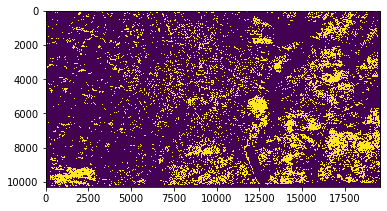

In [9]:
plt.imshow(mask)

In [11]:
pathShapeFiles = Path("./data/shapefiles")
fileShapes = sorted(list(pathShapeFiles.glob("*2011202*.shp")))
fileShapes

[PosixPath('data/shapefiles/segments_2011202_0_v2.shp'),
 PosixPath('data/shapefiles/segments_2011202_1_v2.shp'),
 PosixPath('data/shapefiles/segments_2011202_2_v2.shp'),
 PosixPath('data/shapefiles/segments_2011202_3_v2.shp')]

In [65]:
gdf = gpd.read_file(fileShapes[3])
gdfcrs = gdf.crs
gdf.head()

,seg_index,red_value,blue_value,green_valu,nir_value,red_value_,blue_val_1,green_va_1,nir_value_,area_m,...,dSI_gr,dSI_gn,dSI_rg,dSI_br,dSI_bg,dSI_gb,dSI_nr,land_class,burn_class,geometry
0,72,71.825742,92.908369,67.592823,69.384615,46.011785,71.560381,45.939089,99.692308,2341.12,...,-0.029571,0.356024,0.029571,-0.089322,-0.060326,0.060326,-0.385709,None,None,POLYGON ((-121.5597175149357 39.83756121467142...
1,62,57.444572,70.693841,50.622129,32.000000,53.940919,85.665658,49.555741,118.421053,2969.80,...,-0.020762,0.635358,0.020762,-0.123846,-0.101593,0.101593,-0.658570,None,None,POLYGON ((-121.5651029698989 39.83756121467142...
2,35,66.760227,85.154847,57.801245,50.368421,55.165296,82.634615,51.636616,128.473684,2788.76,...,-0.038885,0.495326,0.038885,-0.078257,-0.039518,0.039518,-0.539145,None,None,POLYGON ((-121.5778664981618 39.83756121467142...
3,27,45.013733,71.137541,43.514310,80.650000,41.461264,62.325086,41.915924,81.750000,2957.09,...,-0.022390,0.023025,0.022390,0.023885,0.045143,-0.045143,-0.043405,None,None,POLYGON ((-121.5818921257468 39.83756121467142...
4,29,43.322585,67.771256,41.192995,69.076923,45.050362,67.165580,44.403019,71.000000,2566.80,...,-0.017961,-0.022399,0.017961,0.022995,0.039894,-0.039894,0.005525,None,None,POLYGON ((-121.5810169893153 39.83756121467142...


In [66]:
prediction_segs = zonal_stats(gdf['geometry'], mask, affine=raster_src_mask.meta['transform'], stats='majority', nodata=-999, all_touched=True)

In [67]:
df = pd.DataFrame(prediction_segs)

In [68]:
gdf['pred_burn'] = df.to_numpy()
gdf.head()

,seg_index,red_value,blue_value,green_valu,nir_value,red_value_,blue_val_1,green_va_1,nir_value_,area_m,...,dSI_gn,dSI_rg,dSI_br,dSI_bg,dSI_gb,dSI_nr,land_class,burn_class,geometry,pred_burn
0,72,71.825742,92.908369,67.592823,69.384615,46.011785,71.560381,45.939089,99.692308,2341.12,...,0.356024,0.029571,-0.089322,-0.060326,0.060326,-0.385709,None,None,POLYGON ((-121.5597175149357 39.83756121467142...,0.0
1,62,57.444572,70.693841,50.622129,32.000000,53.940919,85.665658,49.555741,118.421053,2969.80,...,0.635358,0.020762,-0.123846,-0.101593,0.101593,-0.658570,None,None,POLYGON ((-121.5651029698989 39.83756121467142...,1.0
2,35,66.760227,85.154847,57.801245,50.368421,55.165296,82.634615,51.636616,128.473684,2788.76,...,0.495326,0.038885,-0.078257,-0.039518,0.039518,-0.539145,None,None,POLYGON ((-121.5778664981618 39.83756121467142...,0.0
3,27,45.013733,71.137541,43.514310,80.650000,41.461264,62.325086,41.915924,81.750000,2957.09,...,0.023025,0.022390,0.023885,0.045143,-0.045143,-0.043405,None,None,POLYGON ((-121.5818921257468 39.83756121467142...,0.0
4,29,43.322585,67.771256,41.192995,69.076923,45.050362,67.165580,44.403019,71.000000,2566.80,...,-0.022399,0.017961,0.022995,0.039894,-0.039894,0.005525,None,None,POLYGON ((-121.5810169893153 39.83756121467142...,0.0


In [69]:
gdf = gdf.astype({"pred_burn": int})
gdf = gpd.GeoDataFrame(gdf, crs=gdfcrs)
gdf.head()

,seg_index,red_value,blue_value,green_valu,nir_value,red_value_,blue_val_1,green_va_1,nir_value_,area_m,...,dSI_gn,dSI_rg,dSI_br,dSI_bg,dSI_gb,dSI_nr,land_class,burn_class,geometry,pred_burn
0,72,71.825742,92.908369,67.592823,69.384615,46.011785,71.560381,45.939089,99.692308,2341.12,...,0.356024,0.029571,-0.089322,-0.060326,0.060326,-0.385709,None,None,POLYGON ((-121.5597175149357 39.83756121467142...,0
1,62,57.444572,70.693841,50.622129,32.000000,53.940919,85.665658,49.555741,118.421053,2969.80,...,0.635358,0.020762,-0.123846,-0.101593,0.101593,-0.658570,None,None,POLYGON ((-121.5651029698989 39.83756121467142...,1
2,35,66.760227,85.154847,57.801245,50.368421,55.165296,82.634615,51.636616,128.473684,2788.76,...,0.495326,0.038885,-0.078257,-0.039518,0.039518,-0.539145,None,None,POLYGON ((-121.5778664981618 39.83756121467142...,0
3,27,45.013733,71.137541,43.514310,80.650000,41.461264,62.325086,41.915924,81.750000,2957.09,...,0.023025,0.022390,0.023885,0.045143,-0.045143,-0.043405,None,None,POLYGON ((-121.5818921257468 39.83756121467142...,0
4,29,43.322585,67.771256,41.192995,69.076923,45.050362,67.165580,44.403019,71.000000,2566.80,...,-0.022399,0.017961,0.022995,0.039894,-0.039894,0.005525,None,None,POLYGON ((-121.5810169893153 39.83756121467142...,0


In [70]:
newFileName = fileShapes[3].parent / Path(fileShapes[3].name.split('.shp')[0] + "_pburn.shp")
newFileName

PosixPath('data/shapefiles/segments_2011202_3_v2_pburn.shp')

In [71]:
gdf.to_file(newFileName)

In [3]:
labelPburns()

Reading filepaths...
Going through all shapefiles...
reading raster
reading shapefiles for 2010133
writing to path... data/shapefiles/trainingData/segments_2010133_0_pburn.shp
reading raster
reading shapefiles for 2010311
writing to path... data/shapefiles/trainingData/segments_2010311_0_pburn.shp
reading raster
reading shapefiles for 2010313
writing to path... data/shapefiles/trainingData/segments_2010313_0_pburn.shp
reading raster
reading shapefiles for 2011022
writing to path... data/shapefiles/trainingData/segments_2011022_0_pburn.shp
reading raster
reading shapefiles for 2011023
writing to path... data/shapefiles/trainingData/segments_2011023_0_pburn.shp
reading raster
reading shapefiles for 2011200
writing to path... data/shapefiles/trainingData/segments_2011200_0_pburn.shp
reading raster
reading shapefiles for 2011201
writing to path... data/shapefiles/trainingData/segments_2011201_0_pburn.shp


### Read in buildings for zonal stats

In [4]:
fpBuildings = Path("./data/buildings/Paradise_buildings.shp")

In [5]:
gdf_bldgs = gpd.read_file(fpBuildings)

In [6]:
gdf_bldgs.crs

{'init': 'epsg:4326'}

In [7]:
raster_src_mask, mask = readOneImg("results/predict_mask_rf_mosaic.tif")

RasterioIOError: results/predict_mask_rf_mosaic.tif: No such file or directory

In [ ]:
gdf_bldgs['pred_burn'] = gpd.GeoDataFrame(zonal_stats(gdf_bldgs['geometry'], mask, affine=raster_src_mask.meta['transform'], stats='majority', nodata=-999, all_touched=True)).to_numpy()